In [1]:
#导入
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [2]:
#得到依据均匀分布稀疏化的图像，一般需要gate（0占比）到0.9以上，这里默认取0.9
def spraseImg(img_array,gate=0.9,zero=0):
    """
    img_array:ndarray像素数组
    gate:零占比
    zero:灰度图传0,RGB传(0,0,0)
    """
    img_sparse=img_array.copy()
    for i in range(img_sparse.shape[0]):
        for j in range(img_sparse.shape[1]):
            if(random.random()<gate):
                img_sparse[i][j]=zero
    return img_sparse


In [3]:
#把RGB图转换成灰度图
def rgb2bmp(img_array,rate=[0.2989, 0.5870, 0.1140]):
    """
    img_array:(x,y,3)
    rate:rgb分量的权重
    """
    img_gray=np.dot(img_array,rate)
    return img_gray


In [4]:
#稀疏点基于均匀分布，使用均匀窗就能解决问题，如果是其他分布，窗的权重就要改（想法）
def sliding_window_filter(image,slide_window,stride=1):
    """
    滑窗滤波器
    image:图像矩阵
    slide_window:滑窗
    stride:步长
    """
    # 获取图像尺寸
    height, width = image.shape[:2]

    # 创建空白图像用于存储滤波结果
    filtered_image = np.zeros_like(image, dtype=np.uint8)

    # 定义滑窗大小
    window_height_half=slide_window.shape[1]//2
    window_width_half=slide_window.shape[0]//2

    #修正奇偶窗宽的差别
    if(slide_window.shape[0]%2):#奇数
        modify=1
    else:
        modify=0
        
    
    # 对图像进行滑窗滤波
    for y in range(window_height_half, height - window_height_half,stride):
            for x in range(window_width_half, width - window_width_half,stride):
                # 提取滑窗区域
                window = image[y - window_height_half:y + window_height_half + modify, x - window_width_half:x + window_width_half + modify]

                # 计算滑窗区域的超像素
                if np.count_nonzero(window):
                    window_sum = (slide_window*np.sum(window, axis=(0, 1)))/np.count_nonzero(window)
                else:
                    window_sum=np.zeros_like(window)

                # 将滑窗区域内的像素设置为超像素值
                filtered_image[y - window_height_half:y + window_height_half + modify, x - window_width_half:x + window_width_half + modify] = window_sum

            
    return filtered_image

In [5]:
#中值滤波
def medium_filter(image,windows_size):
    """
    借助opencv的中值滤波函数
    """
    median_blur = cv2.medianBlur(image, windows_size)
    return median_blur

In [6]:
#
def inplant(z,z_l):
    """
    z滤波使用的窗小,z_l使用的窗大
    依据z_l把z中的零替换
    """
    z_copy=z.copy()
    for i in range(z_copy.shape[0]):
        for j in range(z_copy.shape[1]):
            if(z_copy[i,j]==0):
                z_copy[i,j]=z_l[i,j]
    return z_copy
    

In [7]:
#MSA多尺度分析算法
def MSA(image,w,m_w):
    """
    image:待处理的图片(spraseImg返回的)
    w:提供的最小满填充滑窗滤波窗宽度，合适的大就好
    m_w:中值滤波的窗大小
    """
    #初始化
    img_w_small=sliding_window_filter(image,slide_window=np.ones(shape=(w,w)))
    window_size=w-1
    while window_size>=1:
        img_w_big=img_w_small
        img_w_small=sliding_window_filter(image,slide_window=np.ones(shape=(window_size,window_size)))
        img_w_small=inplant(img_w_small,img_w_big)
        img_w_small=medium_filter(img_w_small,m_w)
        window_size-=1
    return img_w_small

In [12]:
#__main__部分开始，往下是函数的实验情况
img=Image.open('2.JPG')
img_arr=np.array(img)
img_gray=rgb2bmp(img_array=img_arr)
img_gray_sparse=spraseImg(img_array=img_gray,gate=0.95,zero=0)#默认接受灰度图

$$w^{2}<log_{gate}(1-P)$$
w的求法，其中，w是最合适的窗宽，是最小的能保证滑窗大概率后不出现黑点的宽度，gate是稀疏生成时零占比，P是大概率事件概率，取0.99效果就还行(否决了，需要实验找没有黑点的w)

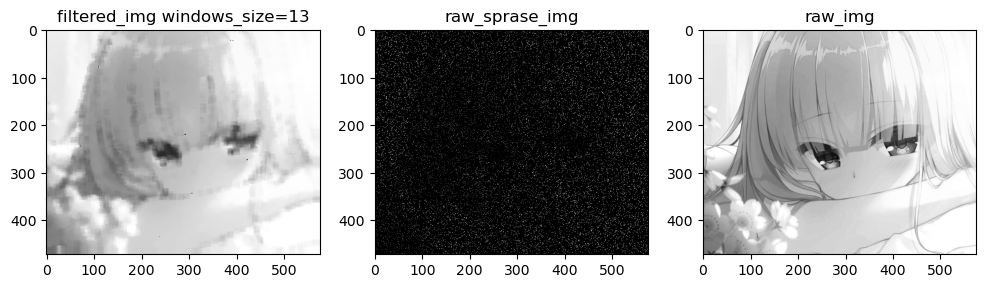

In [15]:
windows_size=13
#这个变量对应w

img_filtered=sliding_window_filter(img_gray_sparse,slide_window=np.ones(shape=(windows_size,windows_size)),stride=1)
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(img_filtered,cmap='gray')
plt.title(f'filtered_img windows_size={windows_size}')

plt.subplot(1,3,2)
plt.imshow(img_gray_sparse,cmap='gray')
plt.title('raw_sprase_img')

plt.subplot(1,3,3)
plt.imshow(img_gray,cmap='gray')
plt.title('raw_img')
plt.show()
#感觉就是，窗开小一点，窗宽最大不能超过原图的0.1，然后步长最好不要超过窗宽的0.6
#窗非常小，就会出现黑点；窗适中，会模糊；窗大，会出现块现象（大小都相对于图片本身大小而言）（窗大小和填充率正相关）
#窗的大小和空间分辨率有关，窗大，会出现像素漂移的问题，窗小，会出现稀疏点干扰的问题

#零占比gate和最合适窗宽w具有关系，MSA从这个最合适的w开始迭代，减小w获取更高轮廓分辨率的图像，再用低分辨率高填充率的图像弥补黑点

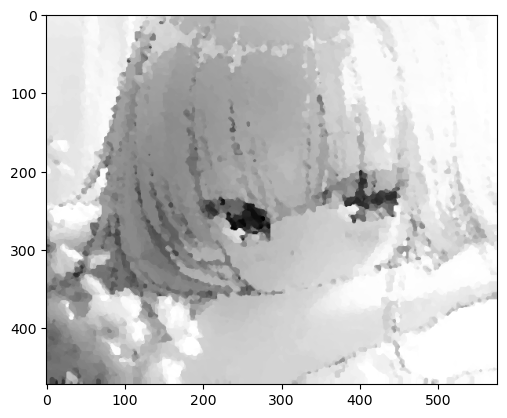

In [16]:
#实验MSA算法的有效性
img_gray_MSA=MSA(img_gray_sparse,15,3)
plt.imshow(img_gray_MSA,cmap='gray')
plt.show()
#意外的有艺术性，虽然该不清楚的细节还是不清楚，但是分辨率确实提高了
#加一点锐化或许能完全复现

In [ ]:
#论文名称是：《单光子探测编码技术及图像重构算法研究_陈松懋》